# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [20]:
from torch import nn, optim
from torch.nn.functional import log_softmax, relu


class Classifier(nn.Module):
    """Classifier network with dropout."""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = relu(self.fc3(x))
        return log_softmax(self.fc4(x), dim=1)

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [8]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [10]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10, :])

tensor([[0],
        [0],
        [0],
        [6],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row. To avoid this, we use the `.view` method on `labels` to turn it into the same shape as `top_class`. (The `*top_class.shape` unpacks the shape values, so in this case it's the same as writing `labels.view(64, 1)`).

In [11]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [13]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy.item()*100}%")

Accuracy: 9.375%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Classifier()
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for _ in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                log_ps = model(images)
                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
        print(f"Accuracy: {accuracy.item()*100}%")

Accuracy: 75.0%
Accuracy: 81.25%
Accuracy: 87.5%
Accuracy: 68.75%
Accuracy: 81.25%
Accuracy: 93.75%
Accuracy: 93.75%
Accuracy: 62.5%
Accuracy: 100.0%
Accuracy: 81.25%
Accuracy: 87.5%
Accuracy: 87.5%
Accuracy: 100.0%
Accuracy: 100.0%
Accuracy: 93.75%
Accuracy: 81.25%
Accuracy: 93.75%
Accuracy: 81.25%
Accuracy: 81.25%
Accuracy: 87.5%
Accuracy: 75.0%
Accuracy: 81.25%
Accuracy: 87.5%
Accuracy: 87.5%
Accuracy: 87.5%
Accuracy: 100.0%
Accuracy: 87.5%
Accuracy: 100.0%
Accuracy: 68.75%
Accuracy: 100.0%


## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    """Classifier network with dropout."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        """ Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [ ]:
class Classifier(nn.Module):
    """Classifier network with dropout."""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """Forward pass through the network, returns the output logits."""
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = self.dropout(relu(self.fc1(x)))
        x = self.dropout(relu(self.fc2(x)))
        x = self.dropout(relu(self.fc3(x)))
        return log_softmax(self.fc4(x), dim=1)

Epoch 1/30: 100%|██████████| 938/938 [00:21<00:00, 44.38batch/s]


Training loss: 0.5139801896203047


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.64batch/s]


Validation loss: 0.45567082409646104
Validation accuracy: 83.28025477707007%



Epoch 2/30: 100%|██████████| 938/938 [00:21<00:00, 43.95batch/s]


Training loss: 0.39171160458882986


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.52batch/s]


Validation loss: 0.427002194865494
Validation accuracy: 84.78304140127389%



Epoch 3/30: 100%|██████████| 938/938 [00:21<00:00, 43.12batch/s]


Training loss: 0.355457564915167


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.50batch/s]


Validation loss: 0.4526849428939212
Validation accuracy: 84.28542993630573%



Epoch 4/30: 100%|██████████| 938/938 [00:22<00:00, 41.05batch/s]


Training loss: 0.3326099253237756


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.49batch/s]


Validation loss: 0.40274394963197646
Validation accuracy: 85.49960191082802%



Epoch 5/30: 100%|██████████| 938/938 [00:22<00:00, 41.56batch/s]


Training loss: 0.31524812412668646


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.78batch/s]


Validation loss: 0.385832426939041
Validation accuracy: 86.59434713375796%



Epoch 6/30: 100%|██████████| 938/938 [00:22<00:00, 42.59batch/s]


Training loss: 0.3012495339313931


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.50batch/s]


Validation loss: 0.4063774466894235
Validation accuracy: 85.89769108280255%



Epoch 7/30: 100%|██████████| 938/938 [00:21<00:00, 42.77batch/s]


Training loss: 0.2918902457332306


Validation: 100%|██████████| 157/157 [00:03<00:00, 44.63batch/s]


Validation loss: 0.3928544122227438
Validation accuracy: 86.86305732484077%



Epoch 8/30: 100%|██████████| 938/938 [00:22<00:00, 41.01batch/s]


Training loss: 0.28845265637964074


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.86batch/s]


Validation loss: 0.3843576746761419
Validation accuracy: 87.16162420382166%



Epoch 9/30: 100%|██████████| 938/938 [00:22<00:00, 42.63batch/s]


Training loss: 0.2747514819555572


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.95batch/s]


Validation loss: 0.3814210832878283
Validation accuracy: 86.74363057324841%



Epoch 10/30: 100%|██████████| 938/938 [00:22<00:00, 42.60batch/s]


Training loss: 0.26749448729222264


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.11batch/s]


Validation loss: 0.3603569448089144
Validation accuracy: 87.41042993630573%



Epoch 11/30: 100%|██████████| 938/938 [00:22<00:00, 42.31batch/s]


Training loss: 0.26143163962087146


Validation: 100%|██████████| 157/157 [00:03<00:00, 44.68batch/s]


Validation loss: 0.3838665826590198
Validation accuracy: 87.21138535031847%



Epoch 12/30: 100%|██████████| 938/938 [00:22<00:00, 42.30batch/s]


Training loss: 0.25440565958174305


Validation: 100%|██████████| 157/157 [00:03<00:00, 44.38batch/s]


Validation loss: 0.3753041993755444
Validation accuracy: 87.35071656050955%



Epoch 13/30: 100%|██████████| 938/938 [00:22<00:00, 42.31batch/s]


Training loss: 0.25011149651682707


Validation: 100%|██████████| 157/157 [00:03<00:00, 44.87batch/s]


Validation loss: 0.3745690643502648
Validation accuracy: 87.92794585987261%



Epoch 14/30: 100%|██████████| 938/938 [00:22<00:00, 41.47batch/s]


Training loss: 0.24141702264038992


Validation: 100%|██████████| 157/157 [00:03<00:00, 44.70batch/s]


Validation loss: 0.39274888167715377
Validation accuracy: 87.33081210191082%



Epoch 15/30: 100%|██████████| 938/938 [00:22<00:00, 41.85batch/s]


Training loss: 0.23852876286659794


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.88batch/s]


Validation loss: 0.3711847654383653
Validation accuracy: 87.56966560509554%



Epoch 16/30: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s]


Training loss: 0.23283787335016962


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.34batch/s]


Validation loss: 0.41469597916124734
Validation accuracy: 86.41520700636943%



Epoch 17/30: 100%|██████████| 938/938 [00:21<00:00, 43.12batch/s]


Training loss: 0.23407809380322758


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.69batch/s]


Validation loss: 0.3950078949142414
Validation accuracy: 87.49004777070064%



Epoch 18/30: 100%|██████████| 938/938 [00:21<00:00, 43.30batch/s]


Training loss: 0.22885098641138596


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.18batch/s]


Validation loss: 0.4079087917592115
Validation accuracy: 87.55971337579618%



Epoch 19/30: 100%|██████████| 938/938 [00:21<00:00, 43.08batch/s]


Training loss: 0.22582283738388945


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.61batch/s]


Validation loss: 0.39200380069624846
Validation accuracy: 87.98765923566879%



Epoch 20/30: 100%|██████████| 938/938 [00:21<00:00, 43.00batch/s]


Training loss: 0.21882214303464015


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.91batch/s]


Validation loss: 0.3811245494682318
Validation accuracy: 88.10708598726114%



Epoch 21/30: 100%|██████████| 938/938 [00:21<00:00, 42.96batch/s]


Training loss: 0.21232975979270077


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.59batch/s]


Validation loss: 0.3992221472179814
Validation accuracy: 87.52985668789809%



Epoch 22/30: 100%|██████████| 938/938 [00:22<00:00, 42.10batch/s]


Training loss: 0.2123092023064015


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.13batch/s]


Validation loss: 0.3887684767603115
Validation accuracy: 87.85828025477707%



Epoch 23/30: 100%|██████████| 938/938 [00:22<00:00, 41.66batch/s]


Training loss: 0.20659566360082962


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.66batch/s]


Validation loss: 0.4262176266616317
Validation accuracy: 87.62937898089172%



Epoch 24/30: 100%|██████████| 938/938 [00:22<00:00, 42.34batch/s]


Training loss: 0.20293853593183986


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.49batch/s]


Validation loss: 0.440221520176359
Validation accuracy: 87.56966560509554%



Epoch 25/30: 100%|██████████| 938/938 [00:22<00:00, 42.31batch/s]


Training loss: 0.20386807895752032


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.41batch/s]


Validation loss: 0.4001288006355049
Validation accuracy: 88.00756369426752%



Epoch 26/30: 100%|██████████| 938/938 [00:21<00:00, 43.42batch/s]


Training loss: 0.19744903605375716


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.17batch/s]


Validation loss: 0.4374596869489949
Validation accuracy: 87.75875796178345%



Epoch 27/30: 100%|██████████| 938/938 [00:21<00:00, 42.90batch/s]


Training loss: 0.19847472851226197


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.35batch/s]


Validation loss: 0.41359675699358533
Validation accuracy: 87.78861464968153%



Epoch 28/30: 100%|██████████| 938/938 [00:21<00:00, 43.06batch/s]


Training loss: 0.19131714030544258


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.04batch/s]


Validation loss: 0.43726385773936655
Validation accuracy: 87.85828025477707%



Epoch 29/30: 100%|██████████| 938/938 [00:21<00:00, 42.84batch/s]


Training loss: 0.18853491599530553


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.95batch/s]


Validation loss: 0.44559783882396237
Validation accuracy: 87.85828025477707%



Epoch 30/30: 100%|██████████| 938/938 [00:21<00:00, 42.82batch/s]


Training loss: 0.18786701412279722


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.32batch/s]


Validation loss: 0.45236691635600323
Validation accuracy: 87.91799363057325%



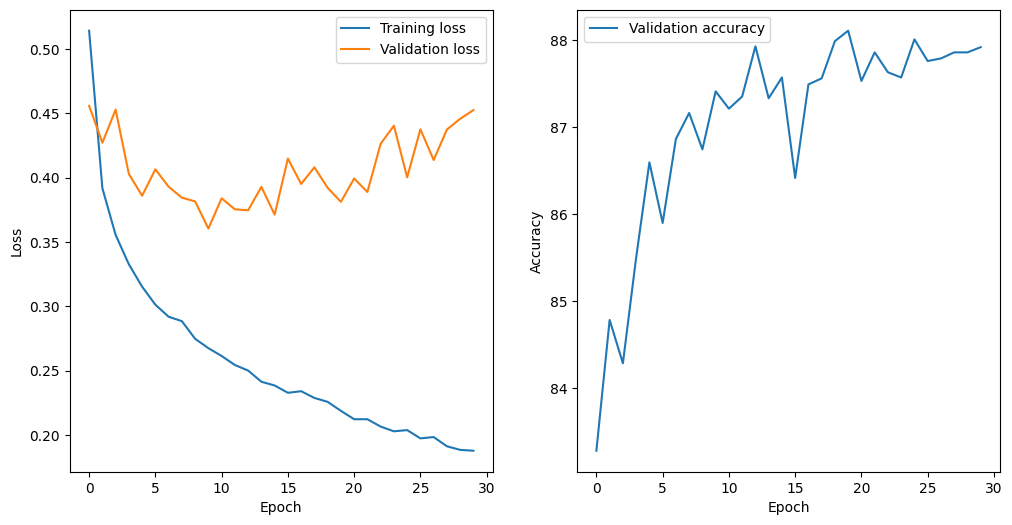

In [28]:
import matplotlib.pyplot as plt
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loss_list = []
validation_loss_list = []
validation_accuracy_list = []


model = Classifier()
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for _ in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in tqdm(trainloader, desc=f"Epoch {_+1}/{epochs}", unit="batch", total=len(trainloader)):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Training loss: {running_loss/len(trainloader)}")
    train_loss_list.append(running_loss/len(trainloader))

    with torch.no_grad():
        model.eval()
        running_val_accuracy = 0
        running_val_loss = 0
        for images, labels in tqdm(testloader, desc=f"Validation", unit="batch", total=len(testloader)):
            images = images.to(device)
            labels = labels.to(device)
            log_ps = model(images)
            ps = torch.exp(model(images))
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            val_accuracy = torch.mean(equals.type(torch.FloatTensor))
            running_val_accuracy += val_accuracy.item()*100
            val_loss = criterion(log_ps, labels)
            running_val_loss += val_loss.item()
        print(f"Validation loss: {running_val_loss/len(testloader)}")
        print(f"Validation accuracy: {running_val_accuracy/len(testloader)}%\n")
        validation_loss_list.append(running_val_loss/len(testloader))
        validation_accuracy_list.append(running_val_accuracy/len(testloader))
        
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training loss")
plt.plot(validation_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(validation_accuracy_list, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()




## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

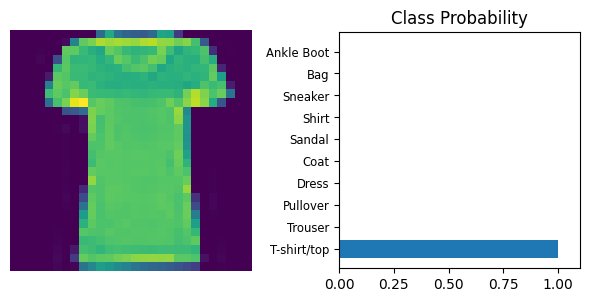

In [32]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output).cpu().detach()

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28).cpu().detach(), ps, version="Fashion")

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model every time you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.